In [1]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import tensorflowjs as tfjs

os.environ["KERAS_BACKEND"] = "tensorflow"

2024-09-03 11:46:31.026482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train/255

5

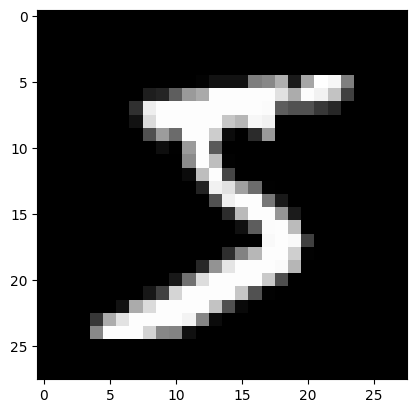

In [3]:
plt.imshow(x_train[0], cmap="gray")
y_train[0]

In [15]:
def sampler(x):
    [log_var, mean] = keras.ops.split(x, 2, axis=-1)
    stddev = ops.exp(0.5*log_var)
    batch = ops.shape(mean)[0]
    dim = ops.shape(mean)[1]
    eps = keras.random.normal(shape=(batch, dim))
    z = mean + eps*stddev
    return z, mean, log_var

class VAE(keras.Model):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(128, activation="relu"),
            layers.Dense(latent_dim*2) # mu and sigmas (this could also be written as two separate dense layers, but combined for tfjs)
        ])
        self.decoder = keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(784, activation="sigmoid")
        ])

    def call(self, x):
        x = self.encoder(x)
        z, mean, log_var = sampler(x)
        recon = self.decoder(z)
        return recon, z, mean, log_var

class Trainer(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.flatten = layers.Flatten(input_shape=(28, 28, 1))
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_term_tracker = keras.metrics.Mean(name="kl_term")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    
    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker, self.kl_term_tracker, self.total_loss_tracker]
    
    def train_step(self, data):
        # forward
        with tf.GradientTape() as tape:
            x = self.flatten(data)
            x_hat, _, mean, log_var = self.model(x)
            kl_term = -0.5*(ops.sum(1 + log_var - mean**2 - ops.exp(log_var), axis=-1))
            recon = ops.sum((x-x_hat)**2, axis=-1)
            loss = ops.mean(recon) + ops.mean(kl_term)
            
        # learn
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update metrics to show during training
        self.reconstruction_loss_tracker.update_state(recon)
        self.kl_term_tracker.update_state(kl_term)
        self.total_loss_tracker.update_state(loss)
        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_term": self.kl_term_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }


ae = VAE(latent_dim=2)
t = Trainer(ae)
t.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
t.fit(x_train, epochs=15, batch_size=128)

/usr/local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_term: 6.5647 - reconstruction_loss: 73.3740 - total_loss: 79.9387
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_term: 2.8018 - reconstruction_loss: 44.1601 - total_loss: 46.9619
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 2.9077 - reconstruction_loss: 41.3592 - total_loss: 44.2670
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_term: 3.0862 - reconstruction_loss: 40.1360 - total_loss: 43.2222
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 3.2128 - reconstruction_loss: 39.4125 - total_loss: 42.6254
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 3.3268 - reconstruction_loss: 38.8340 - total_loss: 42.1608
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_term: 3.3987 - reconstruction_loss: 38.4951 - total_loss: 41.8939
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 3.5033 - reconstruction_loss: 37.9637 - total_loss: 41.4670
Epoch 9/15
469/4

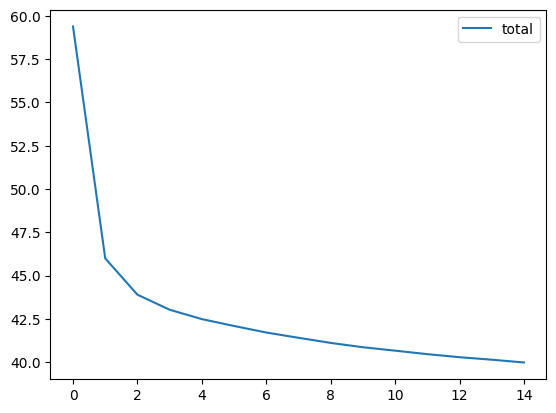

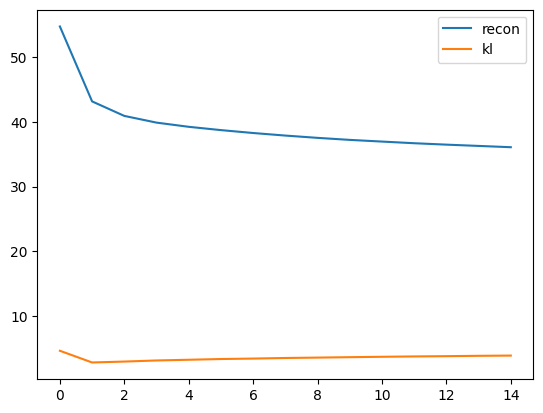

In [16]:
plt.plot(t.history.history["total_loss"], label="total")
plt.legend()
plt.show()
plt.plot(t.history.history["reconstruction_loss"], label="recon")
plt.plot(t.history.history["kl_term"], label="kl")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


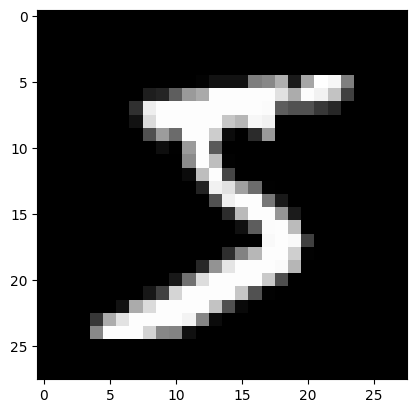

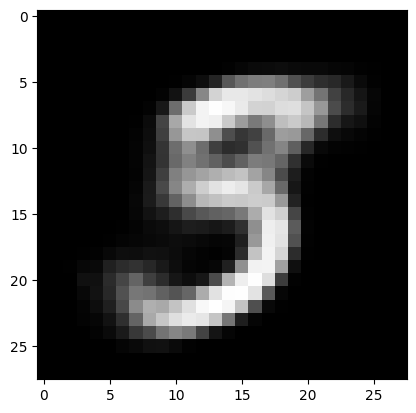

In [12]:
i = 0
recon, _, _, _ = ae.predict(x_train[i].reshape(-1, 784))
plt.imshow(x_train[i], cmap="gray")
plt.show()
plt.imshow(recon.reshape((28, 28)), cmap="gray")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 944us/step


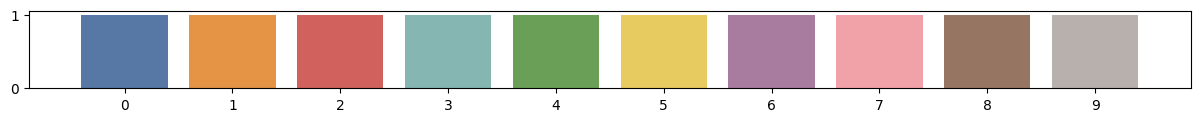

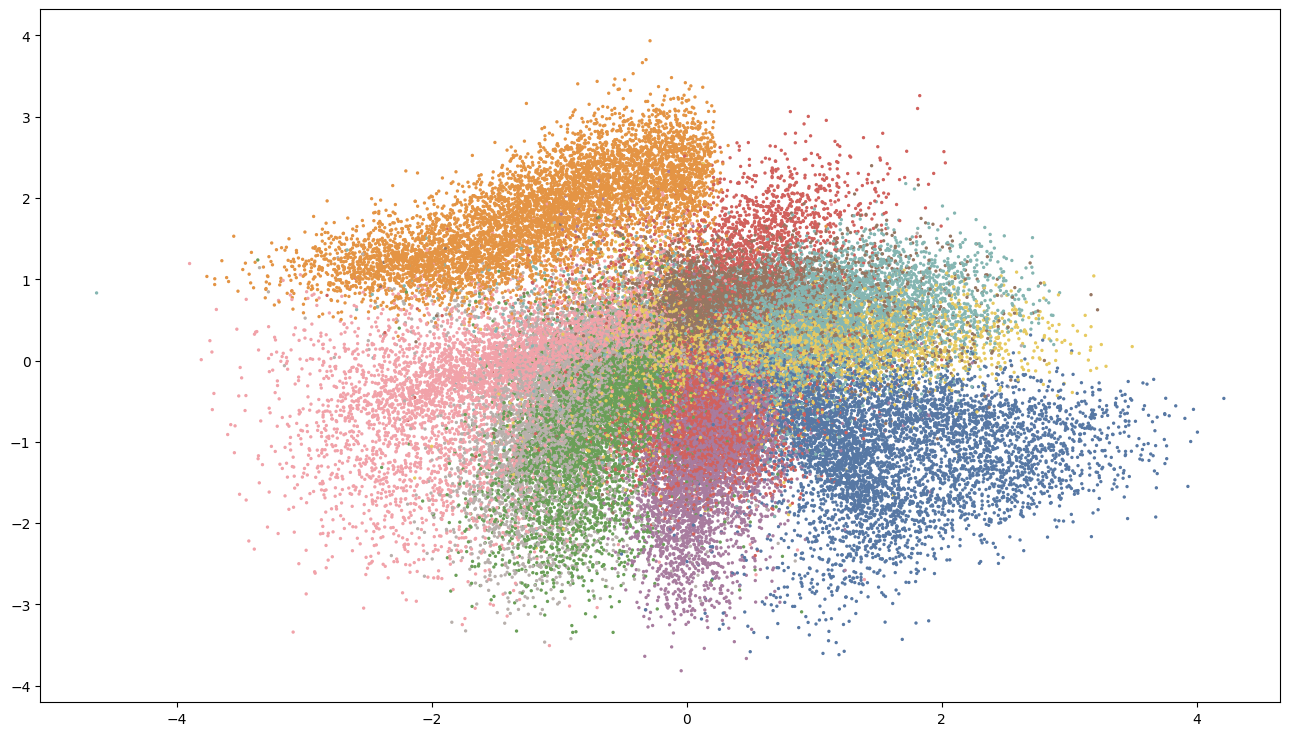

In [17]:
# now visualize the embedding space
def compute_embeddings(model, x_train, y_train):
	_, latents, _, _ = model.predict(x_train.reshape(-1, 784))
	return latents, y_train

def custom_legend(colors, labels):
	fig, ax = plt.subplots()
	fig.set_figwidth(15)
	fig.set_figheight(1)
	ax.bar(labels, [1 for i in range(len(labels))], label=labels, color=colors)
	return ax

def plot_mnist(latents, labels):
	tab10 = ["#5778a4", "#e49444", "#d1615d", "#85b6b2", "#6a9f58", "#e7ca60", "#a87c9f", "#f1a2a9", "#967662", "#b8b0ac"]
	custom_legend(tab10, [str(i) for i in range(10)])
	plt.show()
	plt.figure(figsize=(16, 9))
	plt.scatter(latents[:, 0], latents[:, 1], c=[tab10[i] for i in labels.tolist()], s=2, alpha=1)

latents, labels = compute_embeddings(ae, x_train, y_train)
plot_mnist(latents, labels)

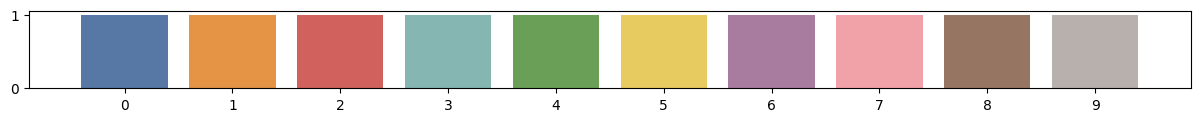

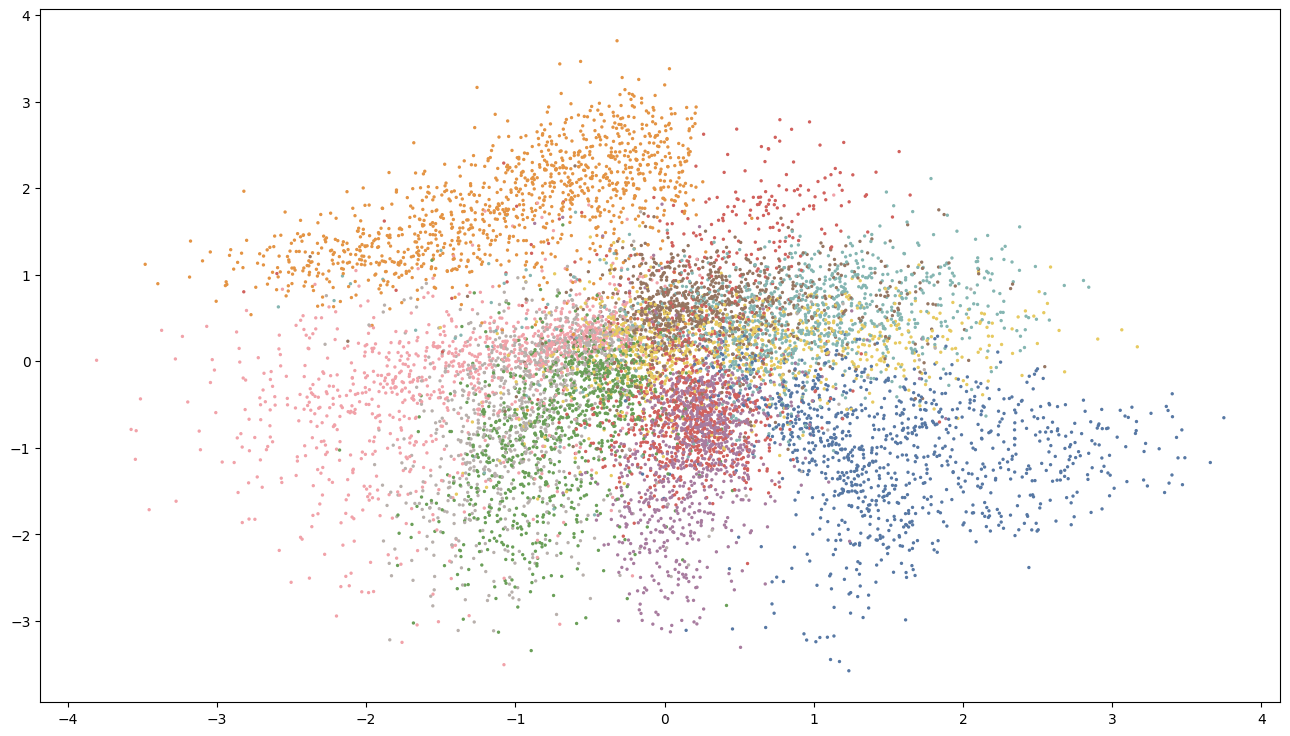

In [21]:
N = 10_000
plot_mnist(latents[:N], labels[:N])

In [26]:
import json
with open("./models/tfjs/latents.json", "w") as f:
	f.write(json.dumps({"points": latents[:N].tolist(), "labels": labels[:N].tolist()}))

In [27]:
tf.saved_model.save(ae.encoder, "models/encoder")
tf.saved_model.save(ae.decoder, "models/decoder")
tfjs.converters.convert_tf_saved_model("models/encoder", "models/tfjs/encoder")
tfjs.converters.convert_tf_saved_model("models/decoder", "models/tfjs/decoder")

INFO:tensorflow:Assets written to: models/encoder/assets


INFO:tensorflow:Assets written to: models/encoder/assets


INFO:tensorflow:Assets written to: models/decoder/assets


INFO:tensorflow:Assets written to: models/decoder/assets
2024-09-03 12:38:14.827661: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-09-03 12:38:14.944614: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
